In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [ ]:
products = pd.read_csv('/counterfeit_product_dataset.csv')

In [ ]:
products

,Product_ID,Product_Name,Brand,Category,Price,Discount_Percentage,Seller_ID,Seller_Rating,Total_Sales,Return_Rate,...,Image_Similarity_Score,Logo_Recognition,Watermark_Detection,Manufacturing_Country,QR_Code_Availability,Reported_As_Fake_By_Users,Price_Anomaly,Keyword_Mismatch,Fraudulent_Seller_Flag,Is_Counterfeit
0,P0001,Ray-Ban Sunglasses,Ray-Ban,Clothing,81265,1,S0001,1.5,6142,0.45,...,0.51,Yes,No,USA,Yes,331,No,Yes,No,0
1,P0002,Adidas T-Shirt,Nike,Clothing,74538,69,S0002,3.5,9334,0.39,...,0.06,No,No,Vietnam,No,204,Yes,No,No,0
2,P0003,Rolex Watch,Adidas,Clothing,52893,16,S0003,4.1,6598,0.39,...,0.07,Yes,Yes,USA,No,364,No,No,Yes,1
3,P0004,Adidas T-Shirt,Rolex,Clothing,66581,27,S0004,3.6,3321,0.23,...,0.57,No,No,Vietnam,Yes,489,No,Yes,Yes,1
4,P0005,Adidas T-Shirt,Rolex,Clothing,29930,65,S0005,3.1,6058,0.20,...,0.57,No,No,USA,Yes,38,Yes,Yes,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,P0496,Nike Shoes,Apple,Shoes,35633,7,S0496,2.1,3728,0.06,...,0.30,No,Yes,Germany,No,224,No,No,Yes,0
496,P0497,Rolex Watch,Nike,Clothing,51177,24,S0497,2.6,7405,0.08,...,0.64,Yes,Yes,China,No,201,Yes,No,Yes,1
497,P0498,Nike Shoes,Nike,Shoes,96559,65,S0498,2.7,4412,0.00,...,0.60,Yes,Yes,USA,No,225,Yes,No,No,1
498,P0499,Nike Shoes,Ray-Ban,Electronics,95088,49,S0499,2.6,4562,0.36,...,0.70,Yes,No,USA,No,235,Yes,Yes,Yes,1


In [ ]:
products.drop(columns=['Product_ID', 'Seller_ID'], inplace=True)

In [ ]:
for col in products.select_dtypes(include=['number']).columns:
    products[col].fillna(products[col].median(), inplace=True)

for col in products.select_dtypes(include=['object']).columns:
    products[col].fillna(products[col].mode()[0], inplace=True)

In [ ]:
products.isnull().sum()

,0
Product_Name,0
Brand,0
Category,0
Price,0
Discount_Percentage,0
Seller_Rating,0
Total_Sales,0
Return_Rate,0
Seller_Verified,0
Customer_Reviews,0


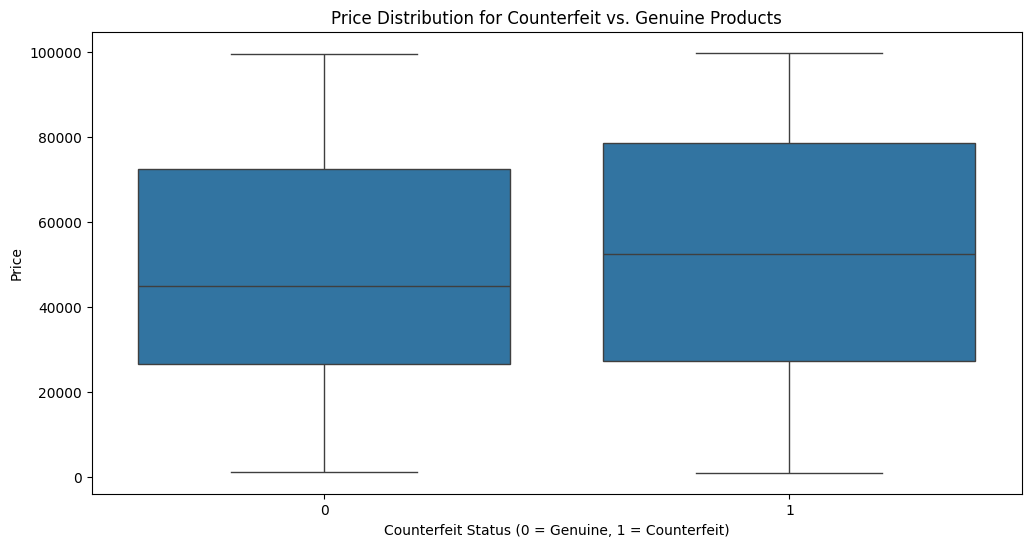

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Is_Counterfeit', y='Price', data=products)
plt.title('Price Distribution for Counterfeit vs. Genuine Products')
plt.xlabel('Counterfeit Status (0 = Genuine, 1 = Counterfeit)')
plt.ylabel('Price')
plt.show()


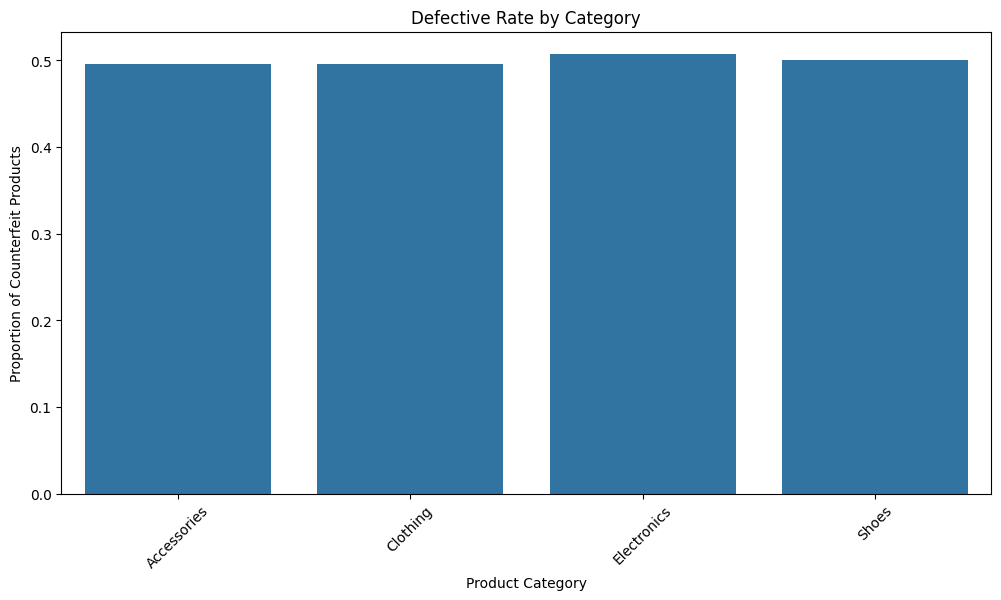

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=products.groupby("Category")["Is_Counterfeit"].mean().index,
            y=products.groupby("Category")["Is_Counterfeit"].mean().values)
plt.xticks(rotation=45)
plt.title("Defective Rate by Category")
plt.xlabel("Product Category")
plt.ylabel("Proportion of Counterfeit Products")
plt.show()

In [ ]:
label_encoders = {}
for col in ['Product_Name', 'Brand', 'Category', 'Seller_Verified', 'Logo_Recognition', 'Watermark_Detection', 'Manufacturing_Country', 'QR_Code_Availability', 'Price_Anomaly', 'Keyword_Mismatch', 'Fraudulent_Seller_Flag']:
    le = LabelEncoder()
    products[col] = le.fit_transform(products[col])
    label_encoders[col] = le

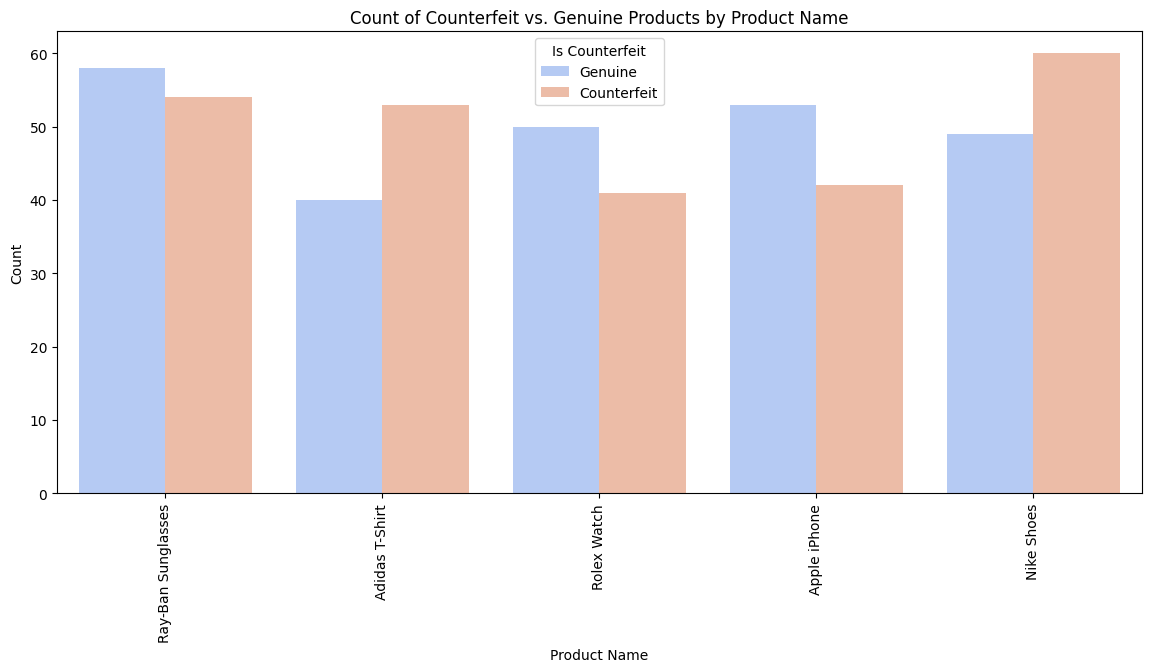

In [ ]:
product_name_mapping = {i: label_encoders['Product_Name'].classes_[i] for i in range(len(label_encoders['Product_Name'].classes_))}
products['Product_Name_Label'] = products['Product_Name'].map(product_name_mapping)

plt.figure(figsize=(14, 6))
sns.countplot(x='Product_Name_Label', hue='Is_Counterfeit', data=products, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Product Name")
plt.ylabel("Count")
plt.title("Count of Counterfeit vs. Genuine Products by Product Name")
plt.legend(title="Is Counterfeit", labels=["Genuine", "Counterfeit"])
plt.show()

In [ ]:
products['Review_Sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [ ]:
products['Sentiment_Score'] = products['Review_Sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})
products.drop(columns=['Customer_Reviews', 'Review_Sentiment'], inplace=True)

In [ ]:
scaler = StandardScaler()
numerical_features = ['Price', 'Discount_Percentage', 'Seller_Rating', 'Total_Sales', 'Return_Rate', 'Product_Rating', 'Number_of_Reviews', 'Image_Similarity_Score', 'Reported_As_Fake_By_Users']
products[numerical_features] = scaler.fit_transform(products[numerical_features])

In [ ]:
X = products.drop(columns=['Is_Counterfeit'])
y = products['Is_Counterfeit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Before applying SMOTE, drop the 'Product_Name_Label' column from your features:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.drop(columns=['Product_Name_Label']), y_train)
# Similarly, drop it from your testing set before prediction:
#y_pred = best_rf.predict(X_test.drop(columns=['Product_Name_Label']))
#and for ensemble_clf
#y_pred2 = ensemble_clf.predict(X_test.drop(columns=['Product_Name_Label']))

In [ ]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
# Drop 'Product_Name_Label' before train-test split
X = products.drop(columns=['Is_Counterfeit', 'Product_Name_Label'])
y = products['Is_Counterfeit']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now apply SMOTE to the resampled training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Proceed with model training and prediction as before
# ...

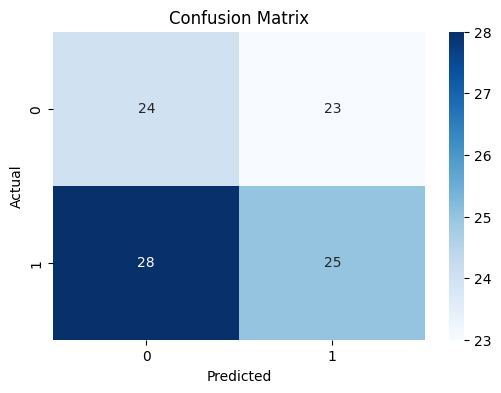

In [ ]:
# Drop 'Product_Name_Label' before train-test split
X = products.drop(columns=['Is_Counterfeit', 'Product_Name_Label'])
y = products['Is_Counterfeit']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now apply SMOTE to the resampled training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)  # Initialize SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Proceed with model training and prediction
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model found by GridSearchCV and fit it
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = best_rf.predict(X_test)

# Now you can generate the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


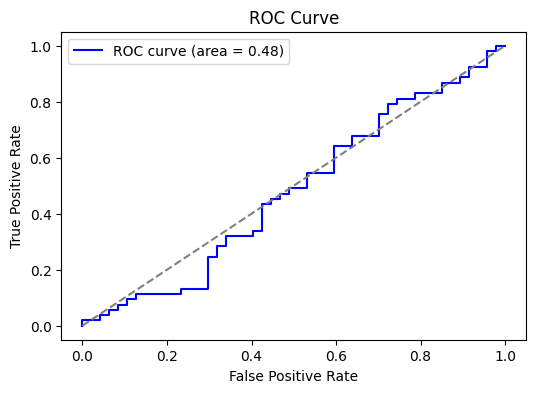

In [ ]:
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
import xgboost as xgb
import lightgbm as lgb

rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgb_model = lgb.LGBMClassifier(random_state=42)
extra_trees = ExtraTreesClassifier(n_estimators=100, random_state=42)

In [ ]:
ensemble_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb_model),
    ('lgb', lgb_model),
    ('et', extra_trees)
], voting='soft')

ensemble_clf.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 203, number of negative: 203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importanc...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgb', LGBMClassifier(random_state=42)),
                             ('et', ExtraTreesClassifier(random_state=42))],
                 voting='soft')

In [ ]:
y_pred2 = ensemble_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 0.49
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.53      0.50        47
           1       0.52      0.45      0.48        53

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100



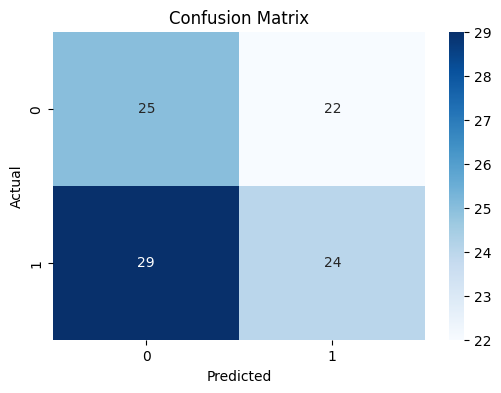

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

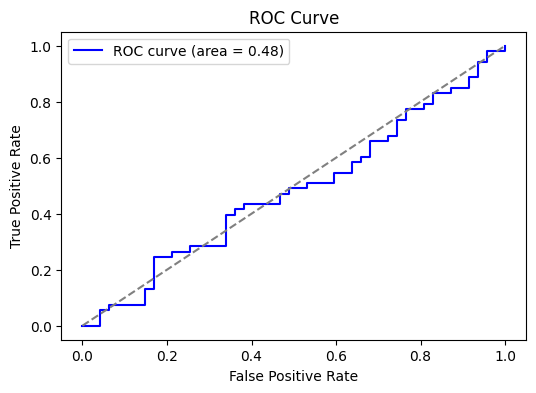

In [ ]:
fpr, tpr, _ = roc_curve(y_test, ensemble_clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()